In [1]:
import copy
import datetime as dt
from datetime import datetime
import importlib  # needed so that we can reload packages
import logging
import os
import pathlib
import sys
import time
import warnings
from typing import Union, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.logger_utils import setup_clean_logger, mute_external_loggers

# SISEPUEDE imports
from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf
import sisepuede.core.attribute_table as att
import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.visualization.plots as svp

# --- Runtime configuration ---
warnings.filterwarnings("ignore")

# Set up a clean logger for your notebook
logger = setup_clean_logger("notebook", logging.INFO)
logger.info("Notebook started successfully.")

# Mute logs from sisepuede to avoid duplication
mute_external_loggers(["sisepuede"])


/Users/fabianfuentes/anaconda3/envs/ssp_MEX/lib/python3.11/site-packages/munch/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-11-12 11:28:39,867 - INFO - Notebook started successfully.


In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under ssp_modeling/config_files/config.yaml

You can also create a new config yaml



In [3]:
# Set up dir paths

CURR_DIR_PATH = pathlib.Path(os.getcwd())
SSP_MODELING_DIR_PATH = CURR_DIR_PATH.parent
PROJECT_DIR_PATH = SSP_MODELING_DIR_PATH.parent
DATA_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("input_data")
RUN_OUTPUT_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("ssp_run_output")
SCENARIO_MAPPING_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("scenario_mapping")
CONFIG_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("config_files")
TRANSFORMATIONS_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("transformations")
MISC_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("misc")
STRATEGIES_DEFINITIONS_FILE_PATH = TRANSFORMATIONS_DIR_PATH.joinpath("strategy_definitions.csv")
STRATEGY_MAPPING_FILE_PATH = MISC_DIR_PATH.joinpath("strategy_mapping.yaml")

In [4]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [5]:
# Load config file, double check your parameters are correct

YAML_FILE_PATH = os.path.join(CONFIG_DIR_PATH, "config.yaml")
config_params = g_utils.read_yaml(YAML_FILE_PATH)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
logger.info(f"Country name: {country_name}")
logger.info(f"SSP input file name: {ssp_input_file_name}")
logger.info(f"SSP transformation CW: {ssp_transformation_cw}")
logger.info(f"Energy model flag: {energy_model_flag}")
logger.info(f"Set lndu reallocation factor to zero flag: {set_lndu_reallocation_factor_to_zero_flag}")

2025-11-12 11:28:39,962 - INFO - Country name: mexico
2025-11-12 11:28:39,963 - INFO - SSP input file name: sisepuede_raw_inputs_MEX_251112.csv
2025-11-12 11:28:39,963 - INFO - SSP transformation CW: ssp_mexico_transformation_cw.xlsx
2025-11-12 11:28:39,963 - INFO - Energy model flag: True
2025-11-12 11:28:39,963 - INFO - Set lndu reallocation factor to zero flag: True


In [6]:
def get_file_structure(
    y0: int = 2015,
    y1: int = 2050,
) -> Tuple[sfs.SISEPUEDEFileStructure, att.AttributeTable]:
    """Get the SISEPUEDE File Structure and update the attribute table
        with new years.
    """
    # setup some SISEPUEDE variables and update time period
    file_struct = sfs.SISEPUEDEFileStructure(
        initialize_directories = False,
    )
 
    # get some keys
    key_time_period = file_struct.model_attributes.dim_time_period
    key_year = file_struct.model_attributes.field_dim_year
 
 
    ##  BUILD THE ATTRIBUTE AND UPDATE
 
    # setup the new attribute table
    years = np.arange(y0, y1 + 1, ).astype(int)
    attribute_time_period = att.AttributeTable(
        pd.DataFrame(
            {
                key_time_period: range(len(years)),
                key_year: years,
            }
        ),
        key_time_period,
    )
 
    # finally, update the ModelAttributes inside the file structure
    (
        file_struct
        .model_attributes
        .update_dimensional_attribute_table(
            attribute_time_period,
        )
    )
 
    # return the tuple
    out = (file_struct, attribute_time_period, )
 
    return out
 
# # setup models
# models = sm.SISEPUEDEModels(
#     matt,
#     allow_electricity_run = True,
#     fp_julia = _FILE_STRUCTURE.dir_jl,
#     fp_nemomod_reference_files = _FILE_STRUCTURE.dir_ref_nemo,
#     initialize_julia = True, 
# )

In [7]:
# Set up SSP objects
INPUT_FILE_PATH = DATA_DIR_PATH.joinpath(ssp_input_file_name)

# model attributes and associated support classes
_EXAMPLES = sxl.SISEPUEDEExamples()
_FILE_STRUCTURE, _ATTRIBUTE_TABLE_TIME_PERIOD = get_file_structure()
matt = _FILE_STRUCTURE.model_attributes
regions = sc.Regions(matt, )
time_periods = sc.TimePeriods(matt, )

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [8]:
INPUT_FILE_PATH

PosixPath('/Users/fabianfuentes/git/ssp_mexico/ssp_modeling/input_data/sisepuede_raw_inputs_MEX_251112.csv')

In [9]:
##  BUILD BASE INPUTS
df_inputs_raw = pd.read_csv(INPUT_FILE_PATH)

# pull example data to fill in gaps
df_example_input = _EXAMPLES("input_data_frame")

In [10]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_example_input, df_inputs_raw)

Columns in df_example but not in df_input: {'region'}
Columns in df_input but not in df_example: {'year', 'iso_alpha_3'}


In [11]:
# Ensure if time_period field exist
if 'time_period' not in df_inputs_raw.columns:
    logger.info("Adding 'time_period' column to df_inputs_raw")
    df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
else:
    logger.info("'time_period' column already exists in df_inputs_raw")

2025-11-12 11:28:40,666 - INFO - 'time_period' column already exists in df_inputs_raw


In [12]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw_complete = g_utils.add_missing_cols(df_example_input, df_inputs_raw.copy())
df_inputs_raw_complete.head()

,year,ef_ippu_tonne_nf3_per_tonne_production_chemicals,ef_ippu_tonne_nf3_per_tonne_production_electronics,ef_ippu_tonne_sf6_per_mmm_gdp_other_product_manufacturing,ef_ippu_tonne_sf6_per_tonne_production_chemicals,ef_ippu_tonne_sf6_per_tonne_production_electronics,ef_ippu_tonne_sf6_per_tonne_production_metals,frac_agrc_bevs_and_spices_cl2_dry,frac_agrc_cereals_cl2_dry,frac_agrc_fibers_cl2_dry,...,nemomod_entc_scalar_availability_factor_pp_geothermal,nemomod_entc_scalar_availability_factor_pp_hydropower,nemomod_entc_scalar_availability_factor_pp_nuclear,nemomod_entc_scalar_availability_factor_pp_ocean,nemomod_entc_scalar_availability_factor_pp_oil,nemomod_entc_scalar_availability_factor_pp_solar,nemomod_entc_scalar_availability_factor_pp_waste_incineration,nemomod_entc_scalar_availability_factor_pp_wind,iso_alpha_3,region
0,2015,0.0,0.0,0.000264,0.0,3.663322e-08,1.403871e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica
1,2016,0.0,0.0,0.000265,0.0,3.982696e-08,1.572880e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica
2,2017,0.0,0.0,0.000266,0.0,3.638876e-08,1.617559e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica
3,2018,0.0,0.0,0.000265,0.0,3.606106e-08,1.608518e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica
4,2019,0.0,0.0,0.000265,0.0,3.455479e-08,1.636647e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica


In [13]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_example_input, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: {'year', 'iso_alpha_3'}


In [14]:
# check region field
df_inputs_raw_complete['region'].unique()

array(['costa_rica', nan], dtype=object)

In [15]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    mexico
1    mexico
2    mexico
3    mexico
4    mexico
Name: region, dtype: object

## Let's Modify the  LNDU Reallocation factor

In [16]:
if set_lndu_reallocation_factor_to_zero_flag:
    df_inputs_raw_complete['lndu_reallocation_factor'] = 0

df_inputs_raw_complete['lndu_reallocation_factor'].mean()

np.float64(0.0)

In [17]:
df_inputs_raw_complete = df_inputs_raw_complete[df_inputs_raw_complete['time_period'].between(0, 35)]
df_inputs_raw_complete['time_period'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

#  Let's try building transformations using this


In [18]:
transformers = trf.transformers.Transformers(
    {},
    attr_time_period = _ATTRIBUTE_TABLE_TIME_PERIOD,
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [19]:
# set an ouput path and instantiate
if not TRANSFORMATIONS_DIR_PATH.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        TRANSFORMATIONS_DIR_PATH,
    )
else:
    logger.info(f"Directory {TRANSFORMATIONS_DIR_PATH} already exists. Skipping instantiation.")


2025-11-12 11:28:41,127 - INFO - Directory /Users/fabianfuentes/git/ssp_mexico/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [20]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

if ssp_transformation_cw is None:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")
else:
    logger.info(f"Using transformation file: {ssp_transformation_cw}")
    cw_file_path = os.path.join(SCENARIO_MAPPING_DIR_PATH, ssp_transformation_cw)
    logger.info(f"Transformation file path: {cw_file_path}")
    excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=TRANSFORMATIONS_DIR_PATH)

2025-11-12 11:28:41,138 - INFO - Using transformation file: ssp_mexico_transformation_cw.xlsx
2025-11-12 11:28:41,138 - INFO - Transformation file path: /Users/fabianfuentes/git/ssp_mexico/ssp_modeling/scenario_mapping/ssp_mexico_transformation_cw.xlsx


In [21]:
# This creates transformation yaml files for each strategy in the excel file
if ssp_transformation_cw is not None:
    logger.info("Processing YAML files...")
    excel_yaml_handler.process_yaml_files()
else:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")

2025-11-12 11:28:41,225 - INFO - Processing YAML files...


[transformation_agrc_dec_ch4_rice.yaml | TX:AGRC:DEC_CH4_RICE] Improve rice management (AGRC) | Start: 12
Strategy: strategy_NDC, Scalar value: 1.0
[transformation_agrc_dec_ch4_rice.yaml | TX:AGRC:DEC_CH4_RICE] Improve rice management (AGRC) | Start: 12
Strategy: strategy_NDC2, Scalar value: 1.0
[transformation_agrc_dec_ch4_rice.yaml | TX:AGRC:DEC_CH4_RICE] Improve rice management (AGRC) | Start: 12
Strategy: strategy_NZ, Scalar value: 1.0
[transformation_agrc_dec_exports.yaml | TX:AGRC:DEC_EXPORTS] Decrease Exports (AGRC) | Start: 12
Strategy: strategy_NZ, Scalar value: 1.0
[transformation_agrc_dec_losses_supply_chain.yaml | TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN] Reduce supply chain losses (AGRC) | Start: 12
Strategy: strategy_NZ, Scalar value: 1.0
[transformation_agrc_inc_conservation_agriculture.yaml | TX:AGRC:INC_CONSERVATION_AGRICULTURE] Expand conservation agriculture (AGRC) | Start: 12
Strategy: strategy_NDC, Scalar value: 1.0
YAML file transformation_agrc_inc_conservation_agriculture

In [22]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct

if ssp_transformation_cw is not None:
    logger.info("Loading transformations per strategy dictionary...")
    transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
    transformation_per_strategy_dict
    logger.info(f"Loaded transformations for strategies: {transformation_per_strategy_dict.keys()}")
else:
    logger.warning("No transformation handler available. Please check your config file.")

2025-11-12 11:28:41,307 - INFO - Loading transformations per strategy dictionary...
2025-11-12 11:28:41,308 - INFO - Loaded transformations for strategies: dict_keys(['strategy_NDC', 'strategy_NDC2', 'strategy_NZ'])


In [23]:
# You can explore the dictionary to see the transformations per strategy
# transformation_per_strategy_dict

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [24]:
# Creating new strategies by updating the strategy_definitions file.

if ssp_transformation_cw is not None:
    # You can edit this to add yours, as many as you want.
    csv_handler = StrategyCSVHandler(csv_file_path=STRATEGIES_DEFINITIONS_FILE_PATH, 
                                     yaml_dir_path=TRANSFORMATIONS_DIR_PATH, 
                                     yaml_mapping_file=STRATEGY_MAPPING_FILE_PATH, 
                                     transformation_per_strategy_dict=transformation_per_strategy_dict)

    csv_handler.add_strategy(strategy_group='PFLO', description='NDC', yaml_file_suffix='NDC')
    csv_handler.add_strategy(strategy_group='PFLO', description='NDC + Energy', yaml_file_suffix='NDC2')
    csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='NZ')
else:
    logger.warning("No transformation handler available. Please check your config file.")


INFO: Strategy code PFLO:NDC already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC
INFO: Strategy code PFLO:NDC2 already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC2
INFO: Strategy code PFLO:NZ already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NZ


### We finished adding new transformation files and strategies so lets load them back

In [25]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    TRANSFORMATIONS_DIR_PATH,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [26]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
logger.info(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

2025-11-12 11:28:43,824 - INFO - Strategies defined at /Users/fabianfuentes/git/ssp_mexico/ssp_modeling/transformations initialized in 2.24 seconds


In [27]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
70,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
71,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
72,6003,PFLO:NDC,NDC,NDC,TX:TRNS:SHIFT_FUEL_RAIL_STRATEGY_NDC|TX:WASO:I...,0
73,6004,PFLO:NDC2,NDC2,NDC + Energy,TX:SOIL:DEC_N_APPLIED_STRATEGY_NDC2|TX:INEN:SH...,0


In [28]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005]

##  Build our templates
- let's use the default variable groupings for LHS

In [29]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = _EXAMPLES("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    # df_trajgroup = df_vargroups,
    # include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [30]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    #id_str = f"sisepuede_run_2025-07-28T12:30:52.790396",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    # try_exogenous_xl_types_in_variable_specification = True,
    attribute_time_period = _ATTRIBUTE_TABLE_TIME_PERIOD
)

2025-11-12 11:28:48,851 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-11-12 11:28:48,852 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-11-12 11:28:48,853 - INFO - 	Setting export engine to 'csv'.
2025-11-12 11:28:48,853 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-11-12 11:28:48,853 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-11-12 11:28:48,854 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-11-12 11:28:48,854 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-11-12 11:28:48,855 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-11-12 11:28:48,855 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-11-12 11:28:48,855 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1596.8 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-11-12 11:29:23,321 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-11-12 11:29:23,334 - INFO - Successfully initialized SISEPUEDEModels.
2025-11-12 11:29:23,340 - INFO - Table ANALYSIS_METADATA successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_MEX/lib/python3

In [31]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-11-12 11:29:23,519 - INFO - 
***	STARTING REGION mexico	***

2025-11-12 11:29:24,607 - INFO - Trying run primary_id = 0 in region mexico
2025-11-12 11:29:24,607 - INFO - Running AFOLU model
2025-11-12 11:29:24,798 - INFO - AFOLU model run successfully completed
2025-11-12 11:29:24,798 - INFO - Running CircularEconomy model
2025-11-12 11:29:24,823 - INFO - CircularEconomy model run successfully completed
2025-11-12 11:29:24,823 - INFO - Running IPPU model
2025-11-12 11:29:24,861 - INFO - IPPU model run successfully completed
2025-11-12 11:29:24,862 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-12 11:29:24,872 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-12 11:29:24,918 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-12 11:29:24,918 - INFO - Running Energy model (Electricity and Fuel Production: trying t

2025-12-Nov 11:29:25.195 Opened SQLite database at /Users/fabianfuentes/anaconda3/envs/ssp_MEX/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-12-Nov 11:29:25.340 Added NEMO structure to SQLite database at /Users/fabianfuentes/anaconda3/envs/ssp_MEX/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-12-Nov 11:29:41.126 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.


2025-11-12 11:31:09,303 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-12 11:31:09,318 - INFO - EnergyProduction model run successfully completed
2025-11-12 11:31:09,319 - INFO - Running Energy (Fugitive Emissions)
2025-11-12 11:31:09,341 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-12 11:31:09,342 - INFO - Appending Socioeconomic outputs
2025-11-12 11:31:09,347 - INFO - Socioeconomic outputs successfully appended.
2025-11-12 11:31:09,350 - INFO - Model run for primary_id = 0 successfully completed in 104.74 seconds (n_tries = 1).
2025-11-12 11:31:09,372 - INFO - Trying run primary_id = 72072 in region mexico
2025-11-12 11:31:09,372 - INFO - Running AFOLU model


2025-12-Nov 11:29:41.593 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-12-Nov 11:29:57.573 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-12-Nov 11:29:57.660 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-12-Nov 11:31:09.137 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-12 11:31:09,583 - INFO - AFOLU model run successfully completed
2025-11-12 11:31:09,583 - INFO - Running CircularEconomy model
2025-11-12 11:31:09,608 - INFO - CircularEconomy model run successfully completed
2025-11-12 11:31:09,608 - INFO - Running IPPU model
2025-11-12 11:31:09,648 - INFO - IPPU model run successfully completed
2025-11-12 11:31:09,648 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-12 11:31:09,658 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-12 11:31:09,705 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-12 11:31:09,706 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-12-Nov 11:31:10.579 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-12-Nov 11:31:10.626 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-12 11:32:03,591 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-12 11:32:03,599 - INFO - EnergyProduction model run successfully completed
2025-11-12 11:32:03,599 - INFO - Running Energy (Fugitive Emissions)
2025-11-12 11:32:03,620 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-12 11:32:03,621 - INFO - Appending Socioeconomic outputs
2025-11-12 11:32:03,626 - INFO - Socioeconomic outputs successfully appended.
2025-11-12 11:32:03,629 - INFO - Model run for primary_id = 72072 successfully completed in 54.26 seconds (n_tries = 1).
2025-11-12 11:32:03,633 - INFO - Trying run primary_id = 73073 in region mexico
2025-11-12 11:32:03,634 - INFO - Running AFOLU model


2025-12-Nov 11:31:20.807 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-12-Nov 11:31:20.872 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-12-Nov 11:32:03.490 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-12 11:32:03,833 - INFO - AFOLU model run successfully completed
2025-11-12 11:32:03,834 - INFO - Running CircularEconomy model
2025-11-12 11:32:03,859 - INFO - CircularEconomy model run successfully completed
2025-11-12 11:32:03,859 - INFO - Running IPPU model
2025-11-12 11:32:03,899 - INFO - IPPU model run successfully completed
2025-11-12 11:32:03,900 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-12 11:32:03,911 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-12 11:32:03,959 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-12 11:32:03,959 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-12-Nov 11:32:04.545 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-12-Nov 11:32:04.590 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-12 11:33:04,693 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-12 11:33:04,699 - INFO - EnergyProduction model run successfully completed
2025-11-12 11:33:04,700 - INFO - Running Energy (Fugitive Emissions)
2025-11-12 11:33:04,721 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-12 11:33:04,722 - INFO - Appending Socioeconomic outputs
2025-11-12 11:33:04,726 - INFO - Socioeconomic outputs successfully appended.
2025-11-12 11:33:04,728 - INFO - Model run for primary_id = 73073 successfully completed in 61.09 seconds (n_tries = 1).
2025-11-12 11:33:04,731 - INFO - Trying run primary_id = 74074 in region mexico
2025-11-12 11:33:04,731 - INFO - Running AFOLU model


2025-12-Nov 11:32:14.554 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-12-Nov 11:32:14.615 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-12-Nov 11:33:04.598 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-12 11:33:04,930 - INFO - AFOLU model run successfully completed
2025-11-12 11:33:04,931 - INFO - Running CircularEconomy model
2025-11-12 11:33:04,954 - INFO - CircularEconomy model run successfully completed
2025-11-12 11:33:04,954 - INFO - Running IPPU model
2025-11-12 11:33:04,993 - INFO - IPPU model run successfully completed
2025-11-12 11:33:04,993 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-12 11:33:05,004 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-12 11:33:05,052 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-12 11:33:05,053 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-12-Nov 11:33:05.635 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-12-Nov 11:33:05.679 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-12 11:33:46,669 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-12 11:33:46,676 - INFO - EnergyProduction model run successfully completed
2025-11-12 11:33:46,676 - INFO - Running Energy (Fugitive Emissions)
2025-11-12 11:33:46,698 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-12 11:33:46,698 - INFO - Appending Socioeconomic outputs
2025-11-12 11:33:46,703 - INFO - Socioeconomic outputs successfully appended.
2025-11-12 11:33:46,705 - INFO - Model run for primary_id = 74074 successfully completed in 41.97 seconds (n_tries = 1).
2025-11-12 11:33:46,707 - INFO - 
***	 REGION mexico COMPLETE	***



2025-12-Nov 11:33:15.615 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-12-Nov 11:33:15.675 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-12-Nov 11:33:46.573 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-12 11:33:46,813 - INFO - Table MODEL_OUTPUT successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_MEX/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-11-12T11;28;48.536409/sisepuede_run_2025-11-12T11;28;48.536409_output_database/MODEL_OUTPUT.csv.
2025-11-12 11:33:46,814 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_MEX/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-11-12T11;28;48.536409/sisepuede_run_2025-11-12T11;28;48.536409_output_database/ATTRIBUTE_PRIMARY.csv.
2025-11-12 11:33:46,941 - INFO - Table MODEL_INPUT successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_MEX/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-11-12T11;28;48.536409/sisepuede_run_2025-11-12T11;28;48.536409_output_database/MODEL_INPUT.csv.


{'mexico': [0, 72072, 73073, 74074]}

# Levers Table


In [32]:
import sisepuede.visualization.tables as svt
tableau_levers_table = svt.LeversImplementationTable(strategies, )
tableau_levers_table_csv = tableau_levers_table.build_table_for_strategies(
    [6003, 6004, 6005]
)

In [33]:
tableau_levers_table_csv

,sector,subsector,transformer_code,transformer_name,transformer_description,transformer_unit,start_period,maximum_magnitude,strategy_PFLO_NDC,strategy_PFLO_NDC2,strategy_PFLO_NZ,year
0,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,12,0.0,0.0,0.0,0.000000,2015
1,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,12,0.0,0.0,0.0,0.000000,2016
2,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,12,0.0,0.0,0.0,0.000000,2017
3,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,12,0.0,0.0,0.0,0.000000,2018
4,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,12,0.0,0.0,0.0,0.000000,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
2083,IPPU,IPPU,TFR:IPPU:DEC_PFCS,IPPU: Reduce use of PFCs,Missing,Fractional reduction in PFC emission factors p...,12,0.0,0.0,0.0,0.082609,2046
2084,IPPU,IPPU,TFR:IPPU:DEC_PFCS,IPPU: Reduce use of PFCs,Missing,Fractional reduction in PFC emission factors p...,12,0.0,0.0,0.0,0.086957,2047
2085,IPPU,IPPU,TFR:IPPU:DEC_PFCS,IPPU: Reduce use of PFCs,Missing,Fractional reduction in PFC emission factors p...,12,0.0,0.0,0.0,0.091304,2048
2086,IPPU,IPPU,TFR:IPPU:DEC_PFCS,IPPU: Reduce use of PFCs,Missing,Fractional reduction in PFC emission factors p...,12,0.0,0.0,0.0,0.095652,2049


In [34]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [35]:
def plot_field_stack(
    df,
    fields,
    dict_format,
    time_col="time_period",
    primary_id=0,
    figsize=(18, 8),
    legend_loc='upper right',
    legend_bbox=(1.1, 1),
    ylabel="MT Emissions CO2e",
    xlabel="Time Period",
    title=None,
):
    """
    Plots a stack plot of the selected fields for a given primary_id.

    Args:
        df (pd.DataFrame): DataFrame containing output data.
        fields (list): List of column names to plot.
        dict_format (dict): Formatting dictionary for colors.
        time_col (str): Name of the time column.
        primary_id (int): Value of primary_id to filter.
        figsize (tuple): Figure size.
        legend_loc (str): Legend location.
        legend_bbox (tuple): Legend bbox_to_anchor.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        title (str): Plot title.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    df_plot = df[df[ssp.key_primary].isin([primary_id])]

    fig, ax = spu.plot_stack(
        df_plot,
        fields,
        dict_formatting=dict_format,
        field_x=time_col,
        figtuple=(fig, ax),
    )

    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox, title="Fields")
    plt.show()

In [36]:
# Define the fields to plot and the formatting dictionary
subsector_emission_fields = matt.get_all_subsector_emission_total_fields()

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

In [37]:
primary_ids_to_plot = df_out[ssp.key_primary].unique()
primary_ids_to_plot

array([    0, 72072, 73073, 74074])

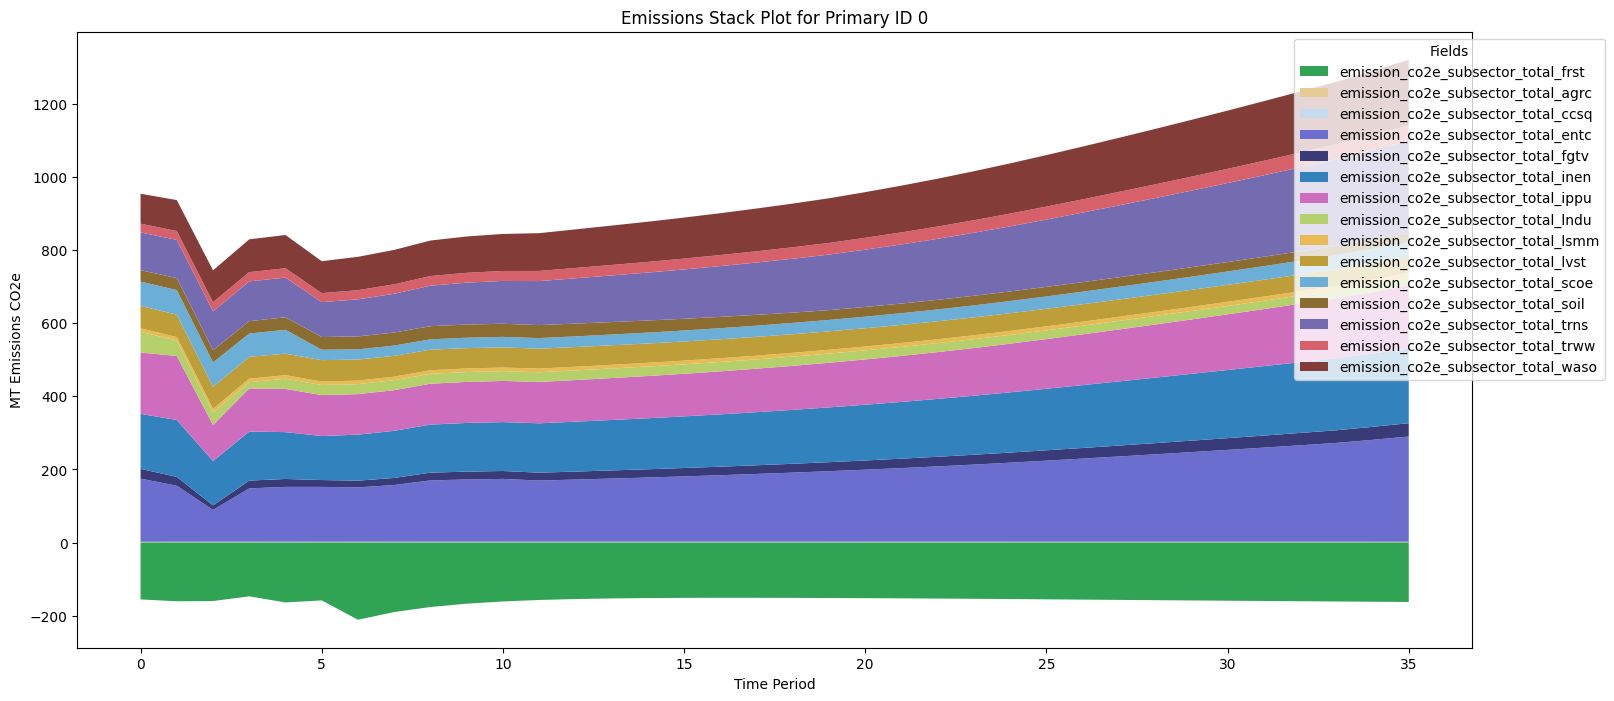

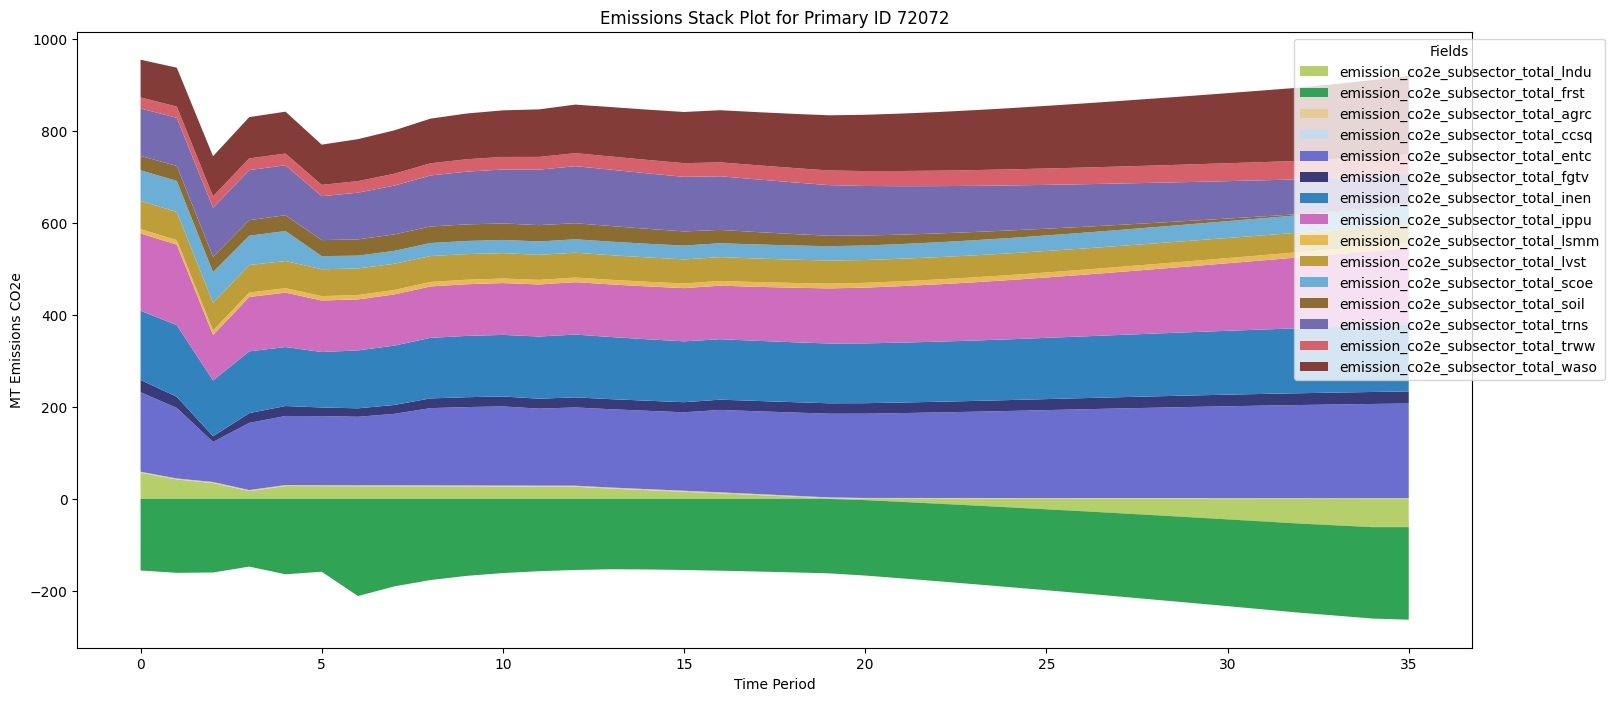

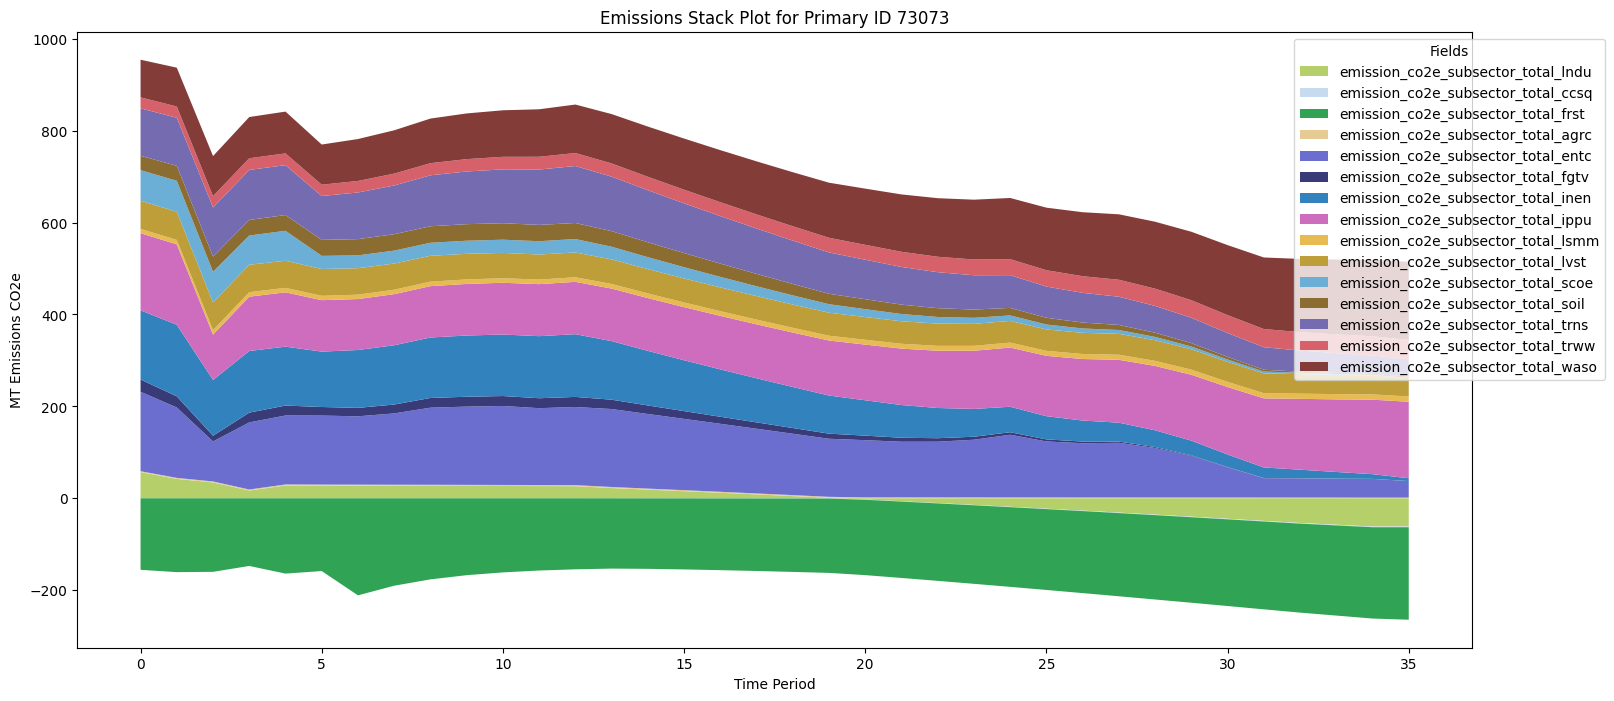

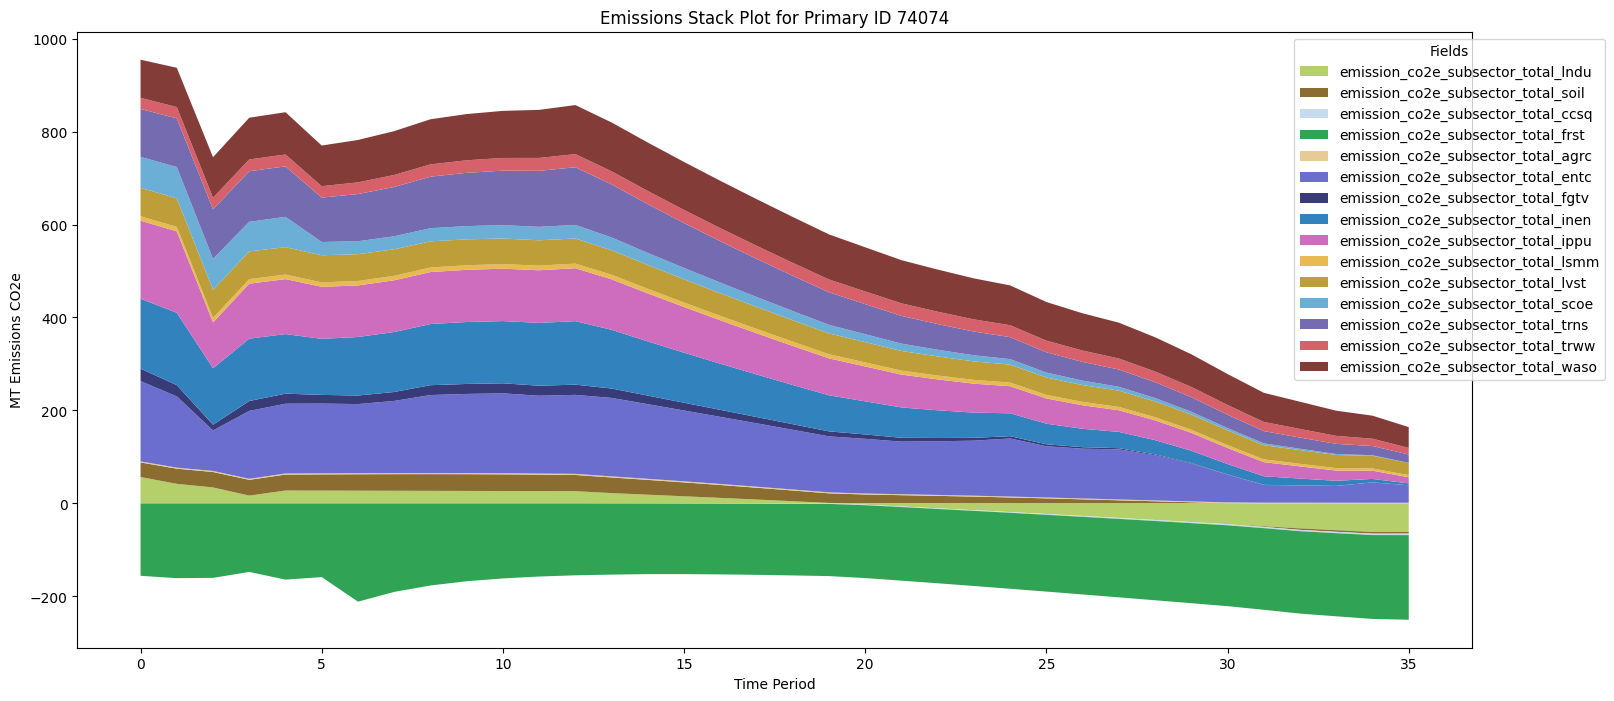

In [38]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)
for primary_id in primary_ids_to_plot:

    plot_field_stack(
        df_out,
        subsector_emission_fields,
        dict_format,
        primary_id=primary_id,
        title=f"Emissions Stack Plot for Primary ID {primary_id}"
    )

# Export Wide File (Last Mandatory Step)

In [39]:
all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [40]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/Users/fabianfuentes/anaconda3/envs/ssp_MEX/lib/python3.11/site-packages/sisepuede/out'

In [41]:
RUN_ID_OUTPUT_DIR_PATH = os.path.join(
    RUN_OUTPUT_DIR_PATH, 
    f"sisepuede_results_{ssp.id_fs_safe}"
)

os.makedirs(RUN_ID_OUTPUT_DIR_PATH, exist_ok=True)

df_primary.to_csv(
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, "ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        logger.warning(f"Warning: Table {tab} returned None.")

In [42]:
tableau_levers_table_csv.to_csv(
            os.path.join(RUN_ID_OUTPUT_DIR_PATH, "tableau_levers_table.csv"),
            index=None,
            encoding="UTF-8"
        )

In [43]:
RUN_ID_OUTPUT_DIR_PATH

'/Users/fabianfuentes/git/ssp_mexico/ssp_modeling/ssp_run_output/sisepuede_results_sisepuede_run_2025-11-12T11;28;48.536409'

In [44]:
# gdp_df = df_in[["time_period", "gdp_mmm_usd"]].copy()
# gdp_df["year"] = gdp_df["time_period"] + 2015
# gdp_df = gdp_df.drop(columns=["time_period"])
# gdp_df.head()